#### Setup

In [3]:
! pip install wand

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01


In [3]:
! brew uninstall imagemagick
! brew install imagemagick@6
! brew unlink imagemagick
! brew link imagemagick@6 --force
! echo 'export MAGICK_HOME="/usr/local/opt/imagemagick@6/lib"' >> ~/.bash_profile
! echo 'export PATH="/usr/local/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

! source ~/.bash_profile

Uninstalling /opt/homebrew/Cellar/imagemagick/7.1.0-51... (805 files, 30.8MB)
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/manifests/6.9.12-
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/blobs/sha256:3681
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring imagemagick@6--6.9.12-66.arm64_monterey.bottle.tar.gz
==> Caveats
imagemagick@6 is keg-only, which means it was not symlinked into /opt/homebrew,
because this is an alternate version of another formula.

If you need to have imagemagick@6 first in your PATH, run:
  echo 'export PATH="/opt/homebrew/opt/imagemagick@6/bin:$PATH"' >> ~/.zshrc

For compilers to find imagemagick@6 you may need to set:
  export LDFLAGS="-L/opt/homebrew/opt/imagemagick@6/lib"
  export CPPFLAGS="-I/opt/homebrew/opt/imagemagick@6

## Font Generation

In [253]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing
from wand.compat import nested
import shutil
import pandas as pd

In [254]:
# Characters 
language = 'abcdefghijklmnopqrstuvwxyz'
language_upper = language.upper()
language += language_upper
language += '0123456789'

assert len(language) == 26 * 2 + 10 
language = language_upper
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [255]:
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 
               'Courier New', 'Helvetica', 'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 
               'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

fonts = handwritten_fonts + typed_fonts 

In [256]:
# Fonts
# handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
#              'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
#              'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello', 'Zapfino']
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 'Courier New', 'Helvetica',
              'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

fonts = handwritten_fonts + typed_fonts 
# fonts = ['Chalkboard']

In [257]:
# resolution
width=200
height=200
font_size=100
background = Color('white')
foreground=Color('rgb(0, 0, 0)')

In [258]:
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [259]:
def delete(language, language_upper):
    for c in language:
        if c in language_upper:
            if os.path.exists(f'{c}{c}'):
                shutil.rmtree(f'{c}{c}')
        else:
            if os.path.exists(c):
                shutil.rmtree(f'{c}')

In [299]:
def generate(fonts, language, language_upper, width=200, height=200, font_size=100, padding=10,
             background=Color('white'), foreground=Color('rgb(0,0,0)')):
    for f in tqdm(fonts):
        for c in language:
            if c in language_upper:
                if not os.path.exists(f'{c}{c}'):
                    os.mkdir(f'{c}{c}')
                filename = os.path.join(f'{c}{c}', f'{f}.png')
            else:
                if not os.path.exists(c):
                    os.mkdir(f'{c}')
                filename = os.path.join(f'{c}', f'{f}.png')

            with Drawing() as draw:
                with Image(width=width, height=height, background=background) as img:
                    draw.font_family = f
                    draw.font_size = font_size
                    draw.push()
                    draw.fill_color = foreground
                    draw.text(0,int(img.height/2), c)
                    draw.pop()
                    draw(img)
                    if os.path.exists(filename):
                        os.unlink(filename)
                    img.save(filename='tmp.png')

                    img = cv2.imread('tmp.png')

                    os.unlink('tmp.png')
                    ys, xs = np.where(np.all(img == (0, 0, 0), axis=-1))
                    
                    if len(ys) > 0 and len(xs) > 0:
                        cropped = img[min(ys):max(ys)+1, min(xs):max(xs)+1]
                        pad_image = np.ones((cropped.shape[0] + 2*padding, cropped.shape[1] + 2*padding, 3)) * 255
                        pad_image[padding:padding + cropped.shape[0], padding:cropped.shape[1] + padding] = cropped
                        # pad_image = cropped
                        cv2.imwrite(filename, pad_image)


In [300]:
generate(fonts, language, language_upper)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:05<00:00,  6.46it/s]


#### Demo

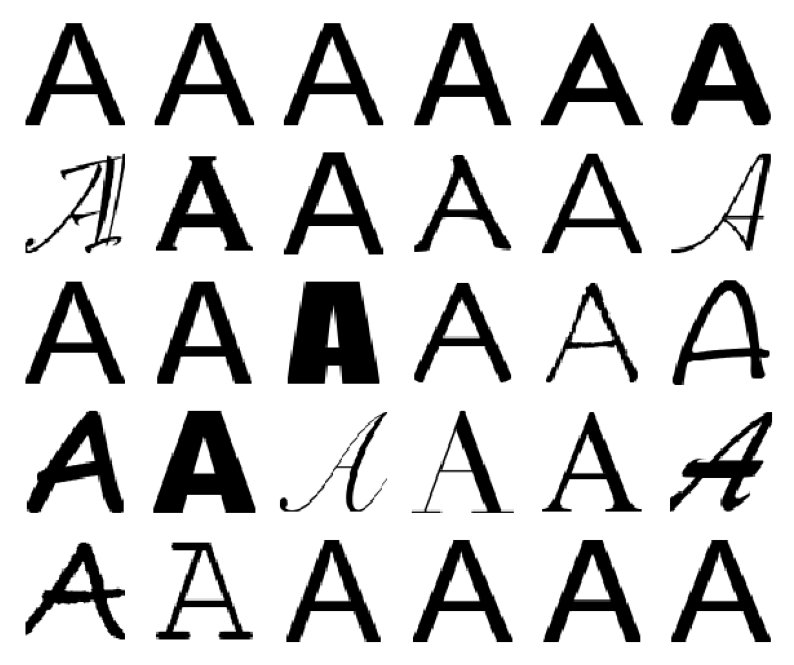

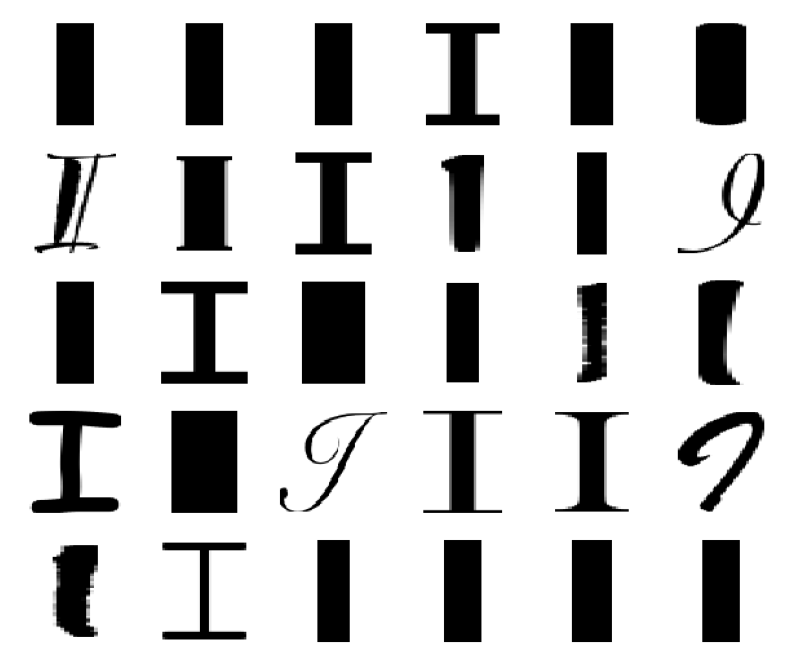

In [305]:
def show_class(character='KK'):
    hstacks = []
    char_images = [resize(read(os.path.join(character, x)), size=(100, 100)) for x in os.listdir(character) if x.endswith('.png')]
    for i in range(5):
        imgs = char_images[i*6:(i+1)*6]
        hstacks.append(np.hstack(imgs))

    plt.figure(figsize=(10, 10))
    show(np.vstack(hstacks))

show_class('AA')
show_class('II')

#### Inference

##### Functions

In [306]:
import matplotlib.pyplot as plt
def show(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.axis('off')
        plt.show()
        
def show_rgb(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def read_rgb(path):
    return cv2.imread(path, cv2.IMREAD_UNCHANGED)

def bin(img, bins=10, min_diff=10):
    count, division = np.histogram(img, bins)
    diff_series = pd.Series(count).diff()
    
    first_histogram_reduction_index = diff_series[(diff_series < 0) & (np.abs(diff_series) > min_diff)].index[0]
    threshold = division[first_histogram_reduction_index+1]
        
    _, img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    return img

def bin_simple(img, thresh=127):
    img[img >= thresh] = 255
    img[img <= thresh] = 0
    return img
    
def bin2(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]

def neg(img):
    return 255 - img

def redraw_contours(img, thickness=16): 
    # Find contours and redraw
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
    # draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness, lineType=cv2.LINE_AA)
    return image_copy

def components(img, min_area=600, show_steps=False):
    # Connected components
    output = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
    num_letters = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    letter_imgs = []
    img_components = img.copy()
    ## Sort letters + area check
    for l in range(1, num_letters):
        minx = stats[l, cv2.CC_STAT_LEFT]
        maxx = stats[l, cv2.CC_STAT_WIDTH] + minx
        miny = stats[l, cv2.CC_STAT_TOP] 
        maxy = stats[l, cv2.CC_STAT_HEIGHT] + miny
        area = stats[l, cv2.CC_STAT_AREA]
        if area < min_area:
            continue

        img_copy = img.copy()
        img_copy[labels != l] = 0
        img_copy[labels == l] = 255
        cropped_img = img_copy[miny:maxy+1, minx: maxx+1].copy()
        if show_steps:
            start_point = (minx, miny)
            end_point = (maxx, maxy)
            color = (255, 255, 255)
            thickness = 3
            img_components = cv2.rectangle(img_components, start_point, end_point, color, thickness)
        
        # Add negatives directly 
        letter_imgs.append((neg(cropped_img), minx, maxx, miny, maxy))
        
    # Show found components boxes
    if show_steps:
        show(img_components)
    
    # Detect spaces and newlines
    sorted_imgs_y = sorted(letter_imgs, 
       key=lambda x: x[3])

    rectangles = sorted_imgs_y.copy()
    
    from collections import defaultdict
    rows = defaultdict(list)
    row_id = 0
    while len(rectangles) > 0:
        r = rectangles[0]
        rows[row_id].append(r)
        ctr_y = (r[3] + r[4])/2
        rectangles.remove(r)
        
        to_remove = []
        for (img, minx, maxx, miny, maxy) in rectangles:
            # if central y line goes through letter box
            if ctr_y >= miny and ctr_y <= maxy:
                rows[row_id].append((img, minx, maxx, miny, maxy))
                to_remove.append((img, minx, maxx, miny, maxy))
        
        for rem in to_remove:
            rectangles.remove(rem)
            
        row_id+=1
    
    final_result = []
    # for y in text
    for row in range(row_id):
        line = []
        # Search for spaces
        sorted_imgs_x = sorted(rows[row], 
           key=lambda x: x[1])
        
        # for char in line
        word = []
        for i in range(0, len(sorted_imgs_x)-1):
            xmax_first = sorted_imgs_x[i][2]
            xmin_second = sorted_imgs_x[i+1][1]

            prev_letter_width = sorted_imgs_x[i][2] - sorted_imgs_x[i][1]
            next_letter_width = sorted_imgs_x[i+1][2] - sorted_imgs_x[i+1][1]
            dist = (xmin_second - xmax_first)
            
            word.append(sorted_imgs_x[i])
            if dist >= max(prev_letter_width, next_letter_width):
                line.append(word)
                word = []
        
        # Assume no space at end of line
        word.append(sorted_imgs_x[-1])
        line.append(word)
        final_result.append(line)
    
    return final_result

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

def erode(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(img, kernel, iterations=it)

def blur(x):
    return cv2.GaussianBlur(x, (3, 3), cv2.BORDER_DEFAULT)

In [307]:
def bin_2(path, show_steps=False):
    x = read(path)
    y = cv2.Laplacian(x, cv2.CV_16S, ksize=3)
    if show_steps:
        show(x)
        show(y)

    # Binarize
    z = y.copy()
    z[z > 127] = 255
    z[z <= 127] = 0
    return z

def pipeline_2(path, show_steps=False, screenshot=False):
    z = bin_2(path, show_steps)
    
    if screenshot:
        thickenings = [1]
    else:
        thickenings = [3]
        
    num_chars = []
    for it in thickenings:
        # Thicken letters
        q = dilate(z, it=it).astype(np.uint8)
        q = erode(z, it=it).astype(np.uint8)
        
        # Find components
        lines = components(q, show_steps=show_steps)
        n_chars = sum([len(w) for line in lines for w in line])
        num_chars.append(n_chars)
    
    max_chars_idx = np.argmax(num_chars)
    it = thickenings[max_chars_idx]
    # Thicken letters
    q = dilate(z, it=it).astype(np.uint8)

    # Find components
    lines = components(q, show_steps=show_steps)

    if show_steps:
        show(z)
        show(q)
        for line in lines:
            for word in line:
                for c in word:
                    show(c[0])
            
    return lines

### NN

In [308]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [439]:
tf.keras.utils.set_random_seed(0)

## Augment Data
size = 96
epochs = 15

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(language), activation='softmax'))
model.summary()


import glob

image_paths = sorted(glob.glob("*/*.png"))
train_labels = np.array(list(range(26)))
classes = sorted(set([i[:i.index('/')] for i in image_paths]))
classes_fmap = dict(zip(classes, train_labels))
classes_imap = dict(zip(train_labels, classes))

train_images = [resize(read(x), size=(size, size))//255 for x in image_paths]
train_labels = np.stack([classes_fmap[i[:i.index('/')]] for i in image_paths])
train_images = np.stack(train_images)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 25600)            

#### Data

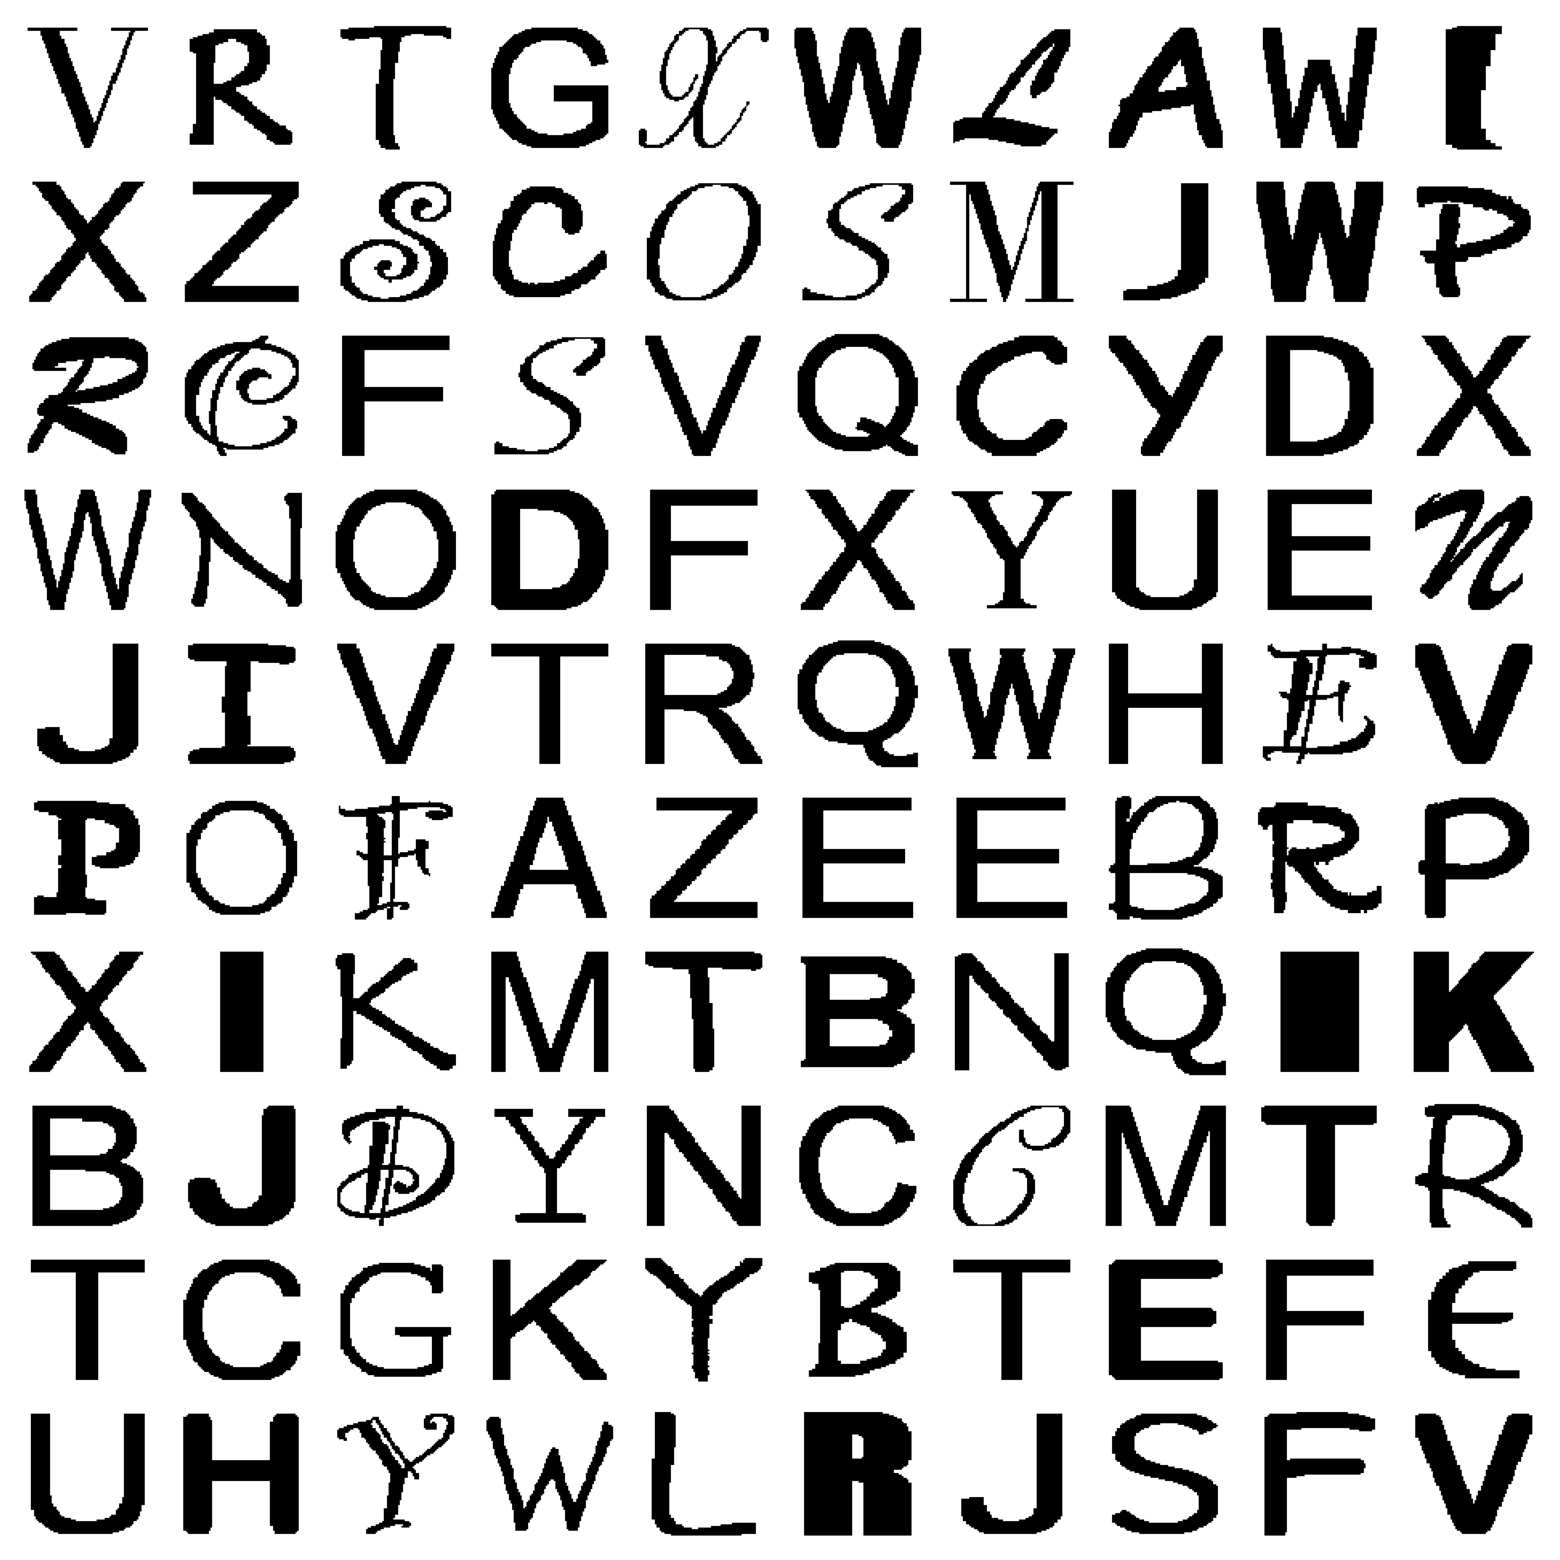

In [440]:
def random_sample(train_images):
    hstacks = []
    np.random.seed(0)
    for _ in range(10):
        idx = np.random.choice(len(train_images), 10)
        sample = train_images[idx]
        hstacks.append(np.hstack(sample))

    plt.figure(figsize=(20, 20))
    show(np.vstack(hstacks))
random_sample(train_images)

#### Augmentation

In [441]:
def augment(train_images, train_labels, 
            dilate_depth=1, 
            erode_depth=2,
            r_from=-5,
            r_to=5,
            r_step=5, 
            padding=10):
    res_images = []
    res_labels = []
    for i in range(train_images.shape[0]):
        img = train_images[i]
        l = train_labels[i]

        # rotation
        # negate for black background
        x = neg(img * 255)
        
        # First, expand the image and translate to center
        new_shape = (int(x.shape[0]*1.5), int(x.shape[1]*1.5))
        tx = (new_shape[0] - x.shape[0])/2
        ty = (new_shape[1] - x.shape[1])/2
        M = np.float32([[1,0,tx],[0,1,ty]])
        dst = cv2.warpAffine(x,M,x.shape)

        translated = cv2.warpAffine(x, M, new_shape)
        
        cx = translated.shape[0]/2
        cy = translated.shape[1]/2
        for d in range(r_from, r_to+1, r_step):
            M = cv2.getRotationMatrix2D((cx, cy),d,1) 
            rotated = cv2.warpAffine(translated, M, (int(x.shape[0]*1.5), int(x.shape[0]*1.5)))
            
            # Reverse negation
            rotated = neg(rotated)
            res_images.append(rotated)
            res_labels.append(l)
                  
            # erosion
            for it in range(1, erode_depth+1):
                rotated_and_eroded = erode(rotated, it=it)
                res_images.append(rotated_and_eroded)
                res_labels.append(l)

            # dilation
            for it in range(1, dilate_depth+1):
                rotated_and_dilated = dilate(rotated, it=it)
                res_images.append(rotated_and_dilated)
                res_labels.append(l)
        
        
    cropped_images = []
    for r in res_images:
        ys, xs = np.where(r==0)

        if len(ys) > 0 and len(xs) > 0:
            cropped = r[min(ys):max(ys)+1, min(xs):max(xs)+1]
            pad_image = np.ones((cropped.shape[0] + 2*padding, cropped.shape[1] + 2*padding)) * 255
            pad_image[padding:padding + cropped.shape[0], padding:cropped.shape[1] + padding] = cropped
            
            resized = resize(pad_image, (size, size))
            if resized.shape[0] > 0:
                cropped_images.append(resized)
        
    return np.stack(cropped_images)//255,np.array(res_labels)  

Total images for training:  17472


<Figure size 2000x2000 with 0 Axes>

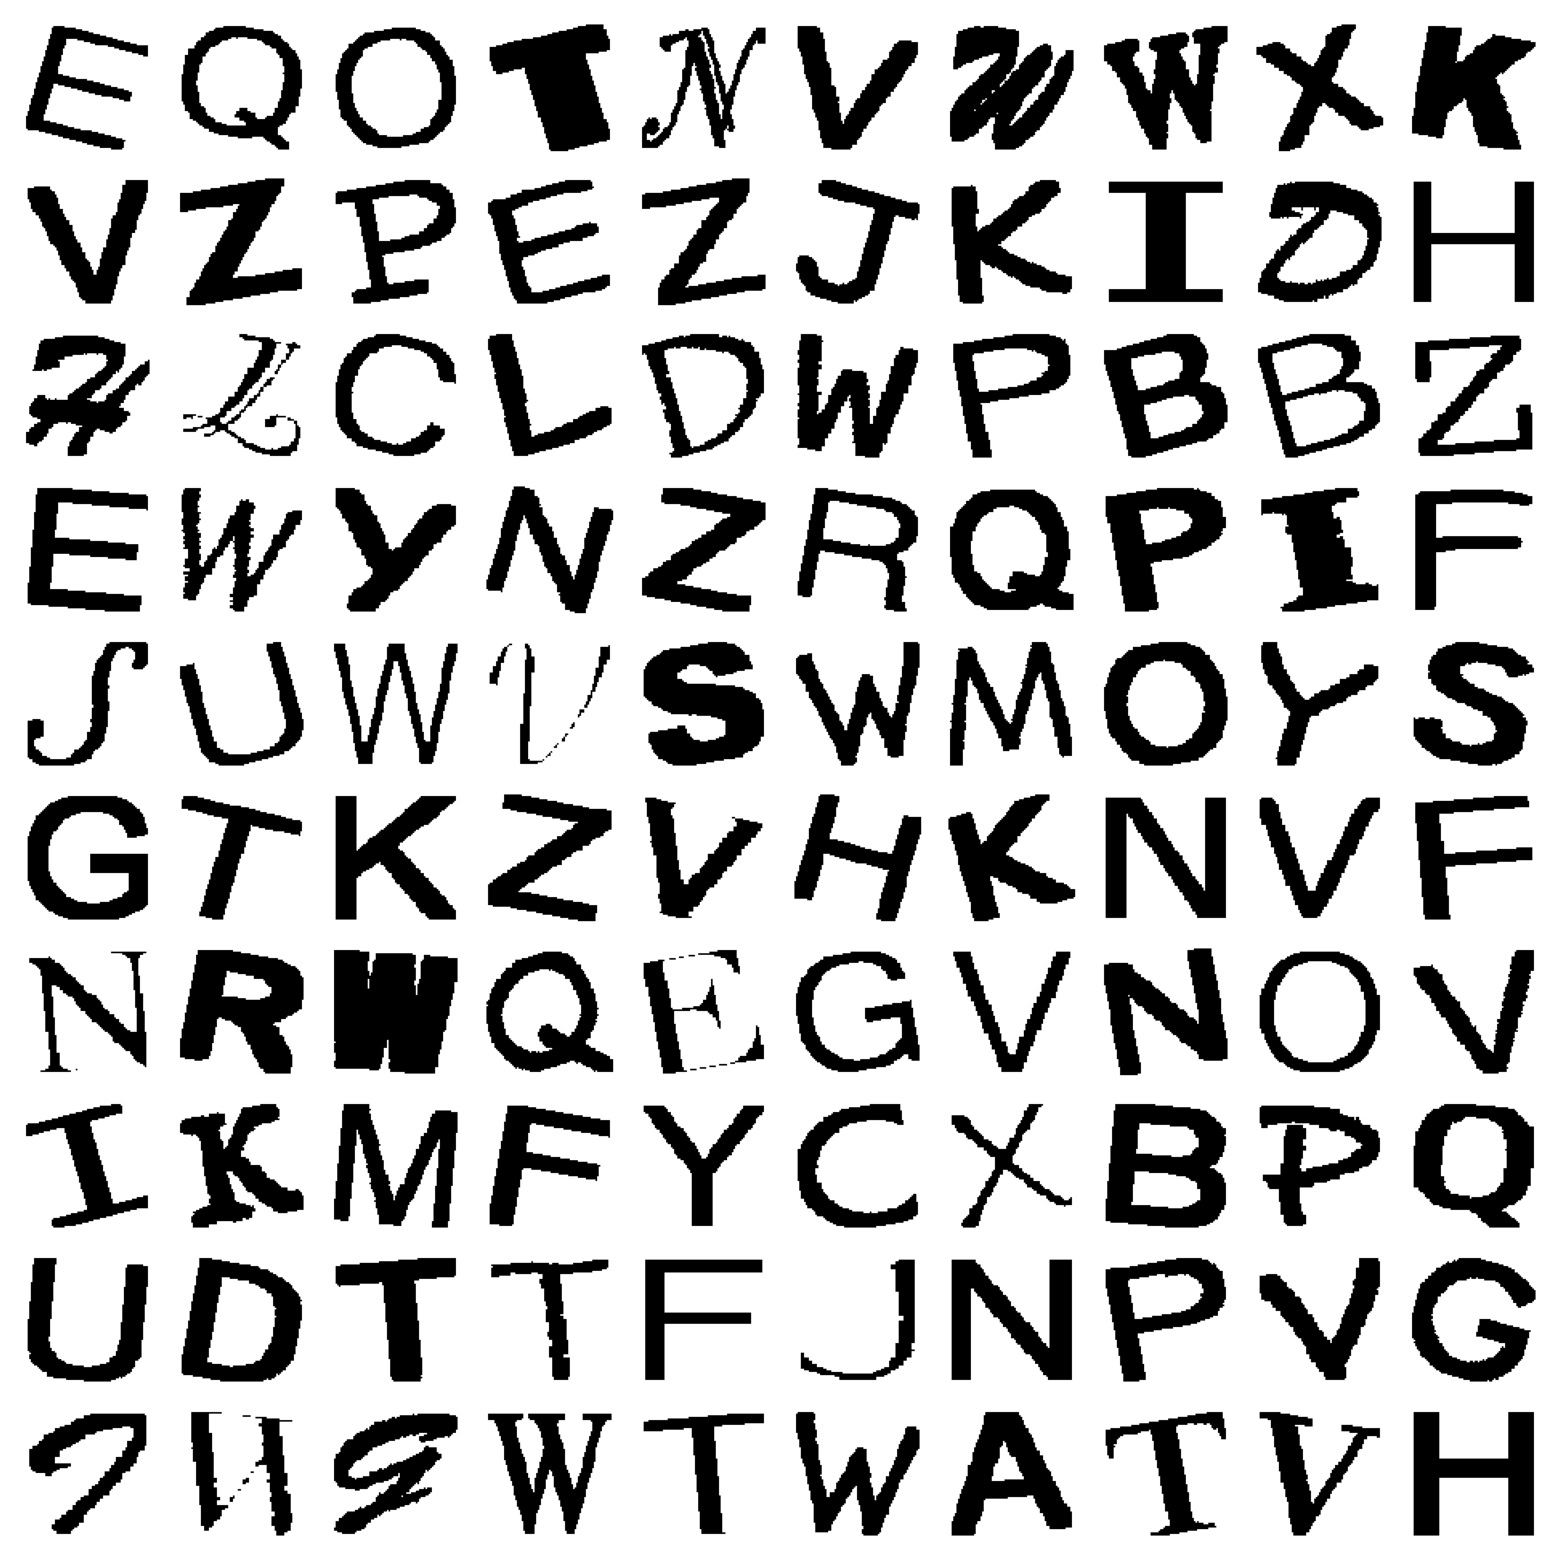

In [442]:
# Augment images 
erode_depth = 1
dilate_depth = 1
r_from = -15
r_to = 16
r_step = 5
train_images_augmented, train_labels_augmented = augment(train_images, train_labels, 
                                                         erode_depth=erode_depth, 
                                                         dilate_depth=dilate_depth,
                                                         r_from=r_from,
                                                         r_to=r_to,
                                                         r_step=r_step)
print('Total images for training: ', len(train_images_augmented))

plt.figure(figsize=(20, 20))

random_sample(train_images_augmented)


In [443]:
# test set
padding = 20
val_images = []
val_classes = []
results = {}
tests = {'btv.png': 'BTV',
         'multiline.mpng': 'FMI\nIMAGE\nPROCESSING',
         'multiline-2.mpng': 'TACTICAL\nDIGITAL',
         'mazalo.mpng': 'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO',
        'team.png': 'TEAM',
        'fmi.png': 'FMI',
        'digital.png': 'DIGITAL',
        'tactical.png': 'TACTICAL',
        'ocr.png': 'OCR',
        'test.png': 'TEST',
        'nova.png': 'NOVA',
        'image.png': 'IMAGE',
        'processing.png': 'PROCESSING',
        'trt1.png': 'TEXT\nRECOGNITION\nPROGRAM\nTEXT',
         'vasko.png': 'VASKO THE\nFROG'
        }

for t, label in tests.items():
    char_count = 0
    for line in pipeline_2(t):
        for word in line:
            for c in word:
                cropped_char = c[0]
                pad_image = np.ones((cropped_char.shape[0] + 2*padding, cropped_char.shape[1] + 2*padding)) * 255
                pad_image[padding:padding + cropped_char.shape[0], padding:cropped_char.shape[1] + padding] = cropped_char
                
                letter_img_res = bin(resize(pad_image, (size, size)))//255
                val_images.append(letter_img_res)

                l = f'{label[char_count]}{label[char_count].upper()}'
                clazz = classes_fmap[l]
                val_classes.append(clazz)
                char_count+=1
            char_count+=1 # space should be counted as character

val_images = np.stack(val_images)
val_classes = np.array(val_classes)
len(val_images), len(val_classes)

(150, 150)

In [444]:
val_images[0].shape

(96, 96)

In [445]:
train_images_augmented[0].shape

(96, 96)

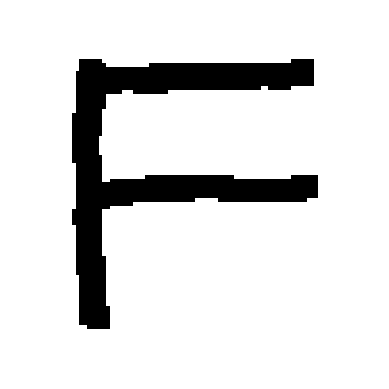

In [446]:
show(val_images[3])

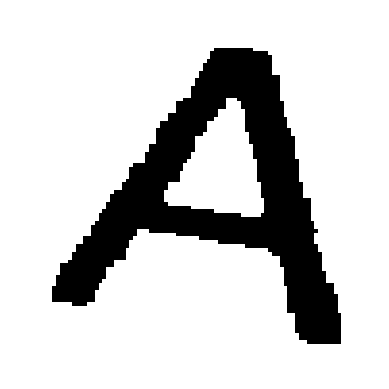

In [447]:
show(train_images_augmented[5])

In [448]:
# Shuffle
idx = np.random.permutation(len(train_images_augmented))
train_images_augmented, train_labels_augmented = train_images_augmented[idx], train_labels_augmented[idx]
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

mcp_save = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(train_images_augmented, train_labels_augmented, 
                    epochs=epochs, validation_data=(val_images, val_classes), callbacks=[mcp_save])


Epoch 1/15
546/546 [==============================] - 35s 64ms/step - loss: 0.4290 - accuracy: 0.8836 - val_loss: 2.4105 - val_accuracy: 0.6333
Epoch 2/15
546/546 [==============================] - 34s 62ms/step - loss: 0.0588 - accuracy: 0.9835 - val_loss: 2.0966 - val_accuracy: 0.7133
Epoch 3/15
546/546 [==============================] - 34s 62ms/step - loss: 0.0295 - accuracy: 0.9920 - val_loss: 2.4062 - val_accuracy: 0.6733
Epoch 4/15
 44/546 [=>............................] - ETA: 31s - loss: 0.0170 - accuracy: 0.9957

KeyboardInterrupt: 

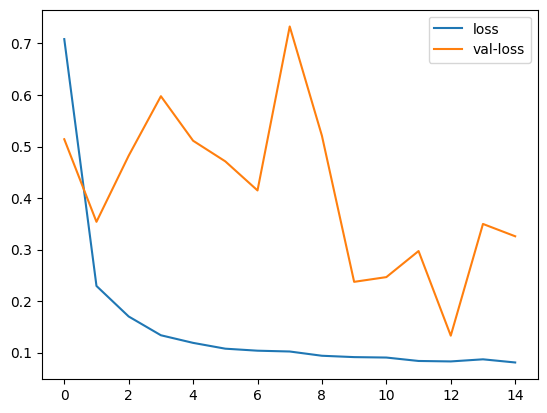

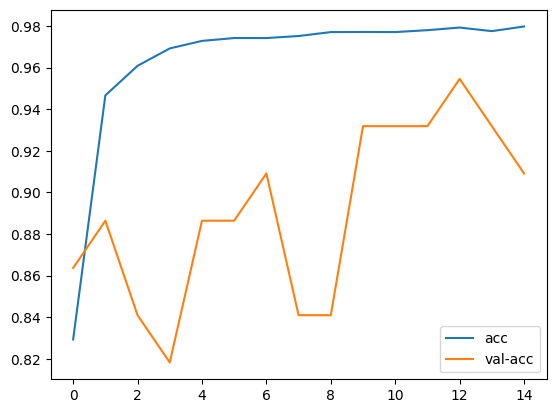

In [1777]:
pd.Series(history.history['loss']).plot()
pd.Series(history.history['val_loss']).plot()
plt.legend(['loss', 'val-loss'])
plt.show()
pd.Series(history.history['accuracy']).plot()
pd.Series(history.history['val_accuracy']).plot()
plt.legend(['acc', 'val-acc'])


In [17]:
model = tf.keras.models.load_model('model.h5')

In [148]:
def classify_nn_augmented(letter_img, inference_size=(size, size), _filter='.png'):
    # Add dilation to inference
    cx = letter_img.shape[0]/2
    cy = letter_img.shape[1]/2
    all_imgs = []
    all_imgs.append(letter_img)
    for d in range(r_from, r_to, r_step):
        M = cv2.getRotationMatrix2D((cx, cy),d,1) 
        rotate = neg(cv2.warpAffine(neg(letter_img),M, x.shape))
        all_imgs += [dilate(rotate, it=i) for i in range(1, dilate_depth)]
        all_imgs += [erode(rotate, it=i) for i in range(1, erode_depth)]
    
    characters = []
    for i, letter_img in enumerate(all_imgs):
        letter_img_res = bin(resize(letter_img, inference_size))//255
        letter_img_tensor = np.stack([letter_img_res])

        results = model.predict(letter_img_tensor, verbose=False)
        char_idx = np.argmax(results)
        character = classes_imap[char_idx][0]
        characters.append({'char': character, 'dilate_it': i, 'result': np.max(results)})
        
    characters = pd.DataFrame(characters)
    return characters['char'].mode().values[0]

def classify_nn(letter_img, inference_size=(size, size), _filter='.png'):
    letter_img_res = bin(resize(letter_img, inference_size))//255
    letter_img_tensor = np.stack([letter_img_res])
        
    results = model.predict(letter_img_tensor, verbose=False)
    char_idx = np.argmax(results)
    character = classes_imap[char_idx][0]
    return character, results

def ocr(path, show_steps, class_fn):
    lines = pipeline_2(path, show_steps=show_steps)
    text = ''
    for il, line in enumerate(lines):
        for iw, word in enumerate(line):
            for c, *_ in word:
                char = class_fn(c)[0]
                text += char
            if iw != len(line) - 1:
                text += ' '
        if il != len(lines) - 1:
            text += '\n'
    return text

def ocr_nn(path, show_steps=False):
    return ocr(path, show_steps, classify_nn)
    
    
def ocr_nn_augmented(path, show_steps=False):
    return ocr(path, show_steps, classify_nn_augmented)

#### Tests NN

In [ ]:
ocr_nn('nova.png', show_steps=True)

In [ ]:
ocr_nn('btv.png', show_steps=True)

In [ ]:
ocr_nn_augmented('test.png')

In [164]:
model = tf.keras.models.load_model('model.h5')


In [241]:
len(tests)

15

In [240]:
sum([len(x) for x in list(tests.values())])

162

In [245]:
# testsheet
results = {}
fns = [ocr_nn]
# fns = [ocr_nn]
# tests = [x for x in os.listdir('.') if x.endswith('.png') or x.endswith('.jpg')]
tests = {'btv.png': 'BTV',
         'multiline.mpng': 'FMI\nIMAGE\nPROCESSING',
         'multiline-2.mpng': 'TACTICAL\nDIGITAL',
         'mazalo.mpng': 'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO',
        'team.png': 'TEAM',
        'fmi.png': 'FMI',
        'digital.png': 'DIGITAL',
        'tactical.png': 'TACTICAL',
        'ocr.png': 'OCR',
        'test.png': 'TEST',
        'nova.png': 'NOVA',
        'image.png': 'IMAGE',
        'processing.png': 'PROCESSING',
        'trt1.png': 'TEXT\nRECOGNITION\nPROGRAM\nTEXT',
         'vasko.png': 'VASKO THE\nFROG'
        # 'guitar.png': 'ON THE GUITAR\nVASKO THE\nFROG'
        # 'screenshot.png': 'OCR\nGEORGI PACHOV\nIMAGE PROCESSING COURSE\n'
        }
for fn in fns:
    num_correct = 0
    num_total = 0
    
    for t, label in tests.items():
        num_total += len(label)

        result = ''.join(fn(t))
        for i in range(min(len(label), len(result))):
            if label[i] == result[i]:
                num_correct+=1
        print(t, result)
        
    results[fn] = num_correct/num_total
results

btv.png BTV
multiline.mpng FMI
IMAGE
PROCESSLNG
multiline-2.mpng TACTICAL
DFGYTAL
mazalo.mpng TOTAL SHTETA
LESHTA BOB
MAZZALLO
team.png TEAM
fmi.png FMI
digital.png DIGLTAL
tactical.png TACTICAL
ocr.png OCR
test.png TEST
nova.png NOVA
image.png IMAGE
processing.png PROCESSLNG
trt1.png TEXT
RECDGNNTIDN
PROGRAM
TEST
vasko.png VASKO THE
FROG


{<function __main__.ocr_nn(path, show_steps=False)>: 0.9444444444444444}

### Tests multiline

In [2087]:
r = ocr_nn('mazalo.mpng')
print(r)

TOTAL SHTETA 
LESHTA BOB 
MAZZALLO 



In [23]:
r = ocr_nn('multiline.mpng')
print(r)

FMI 
IMAGE 
PROCESSLNG 



In [2089]:
r = ocr_nn('multiline-2.mpng')
print(r)

TACTICAL 
DFGYTAL 



#### Debug 

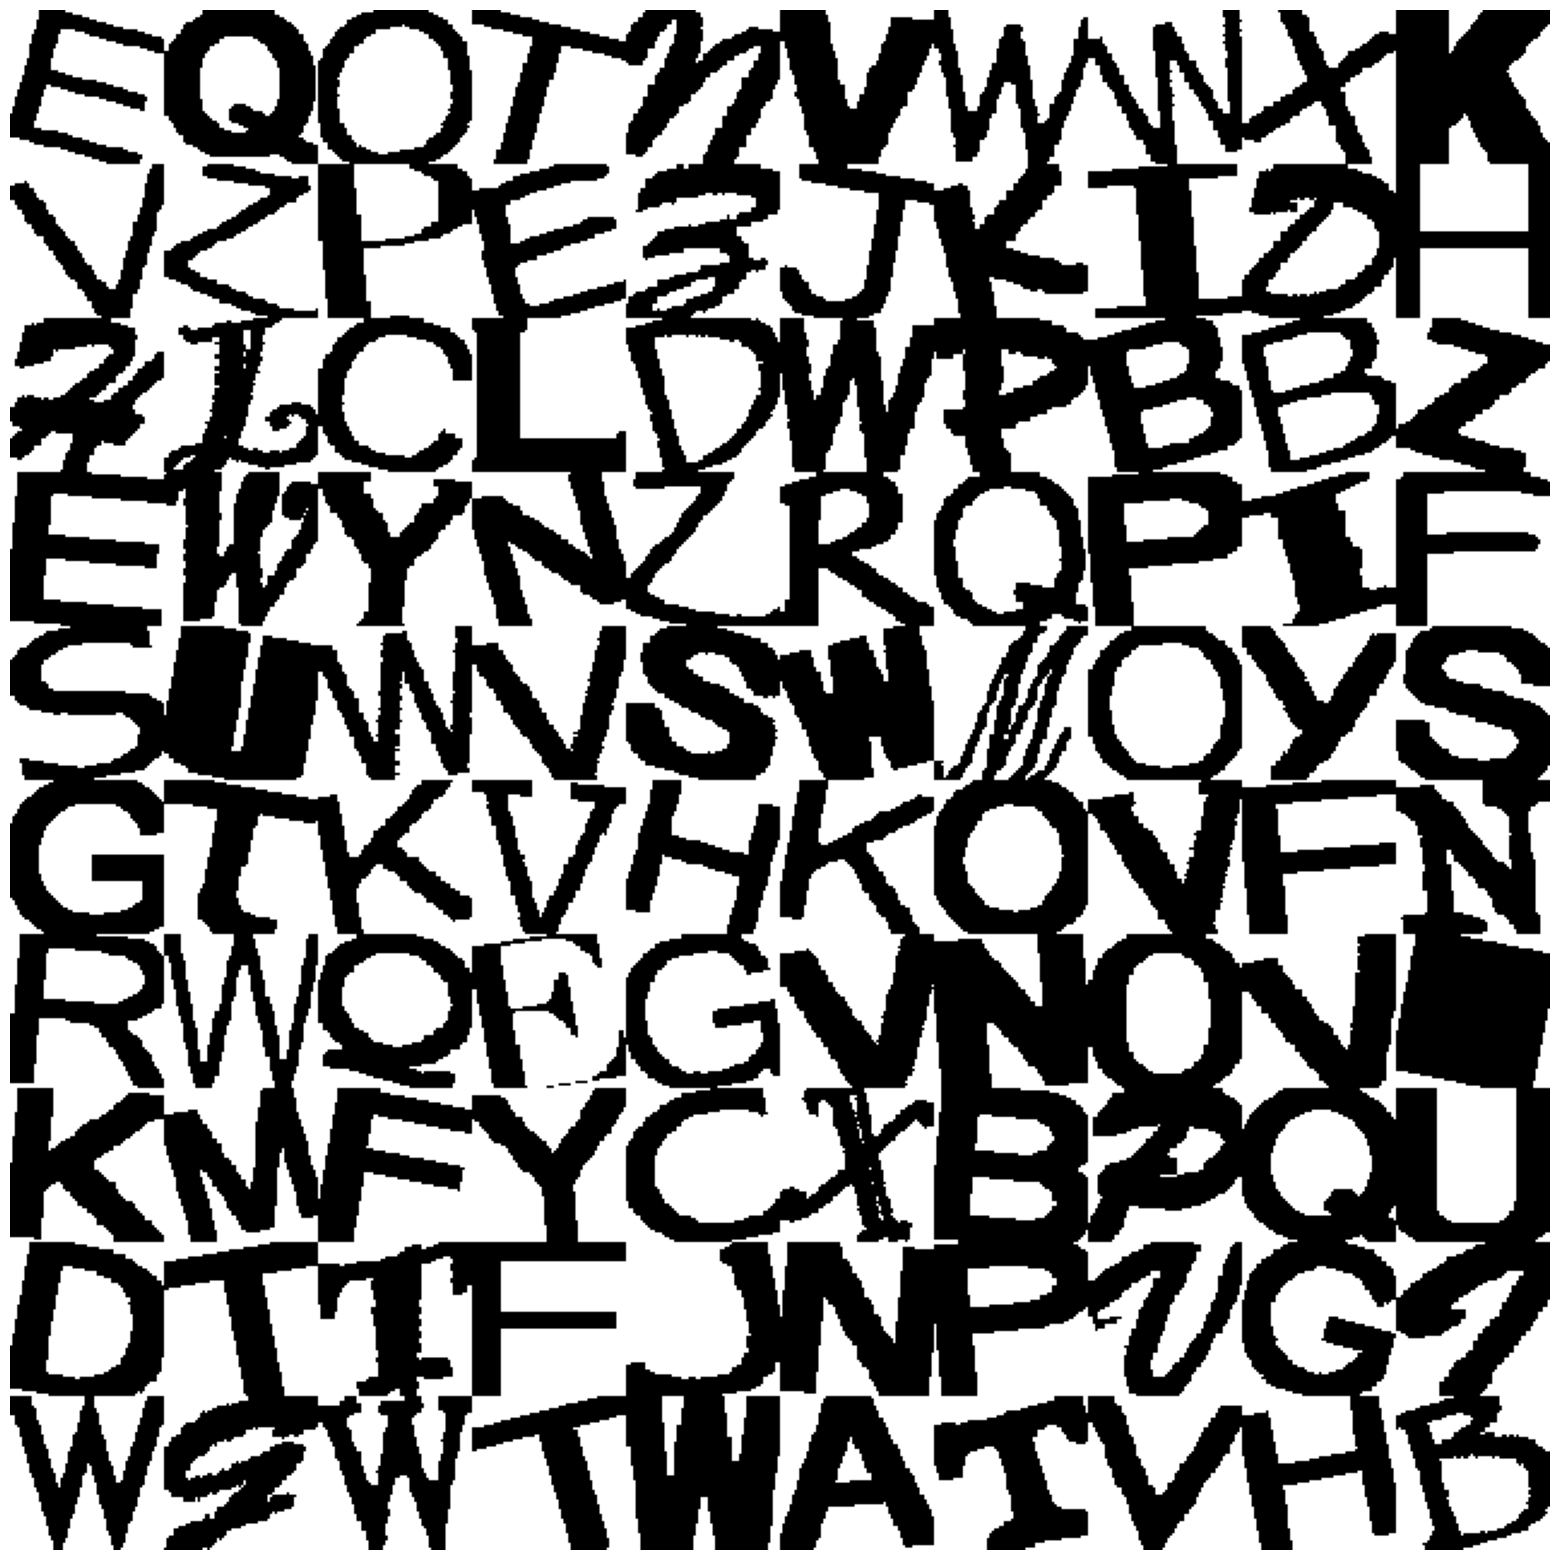

In [165]:
plt.figure(figsize=(20, 20))

hstacks = []
np.random.seed(0)
for _ in range(10):
    idx = np.random.choice(len(train_images_augmented), 10)
    sample = train_images_augmented[idx]
    hstacks.append(np.hstack(sample))
    
show(np.vstack(hstacks))


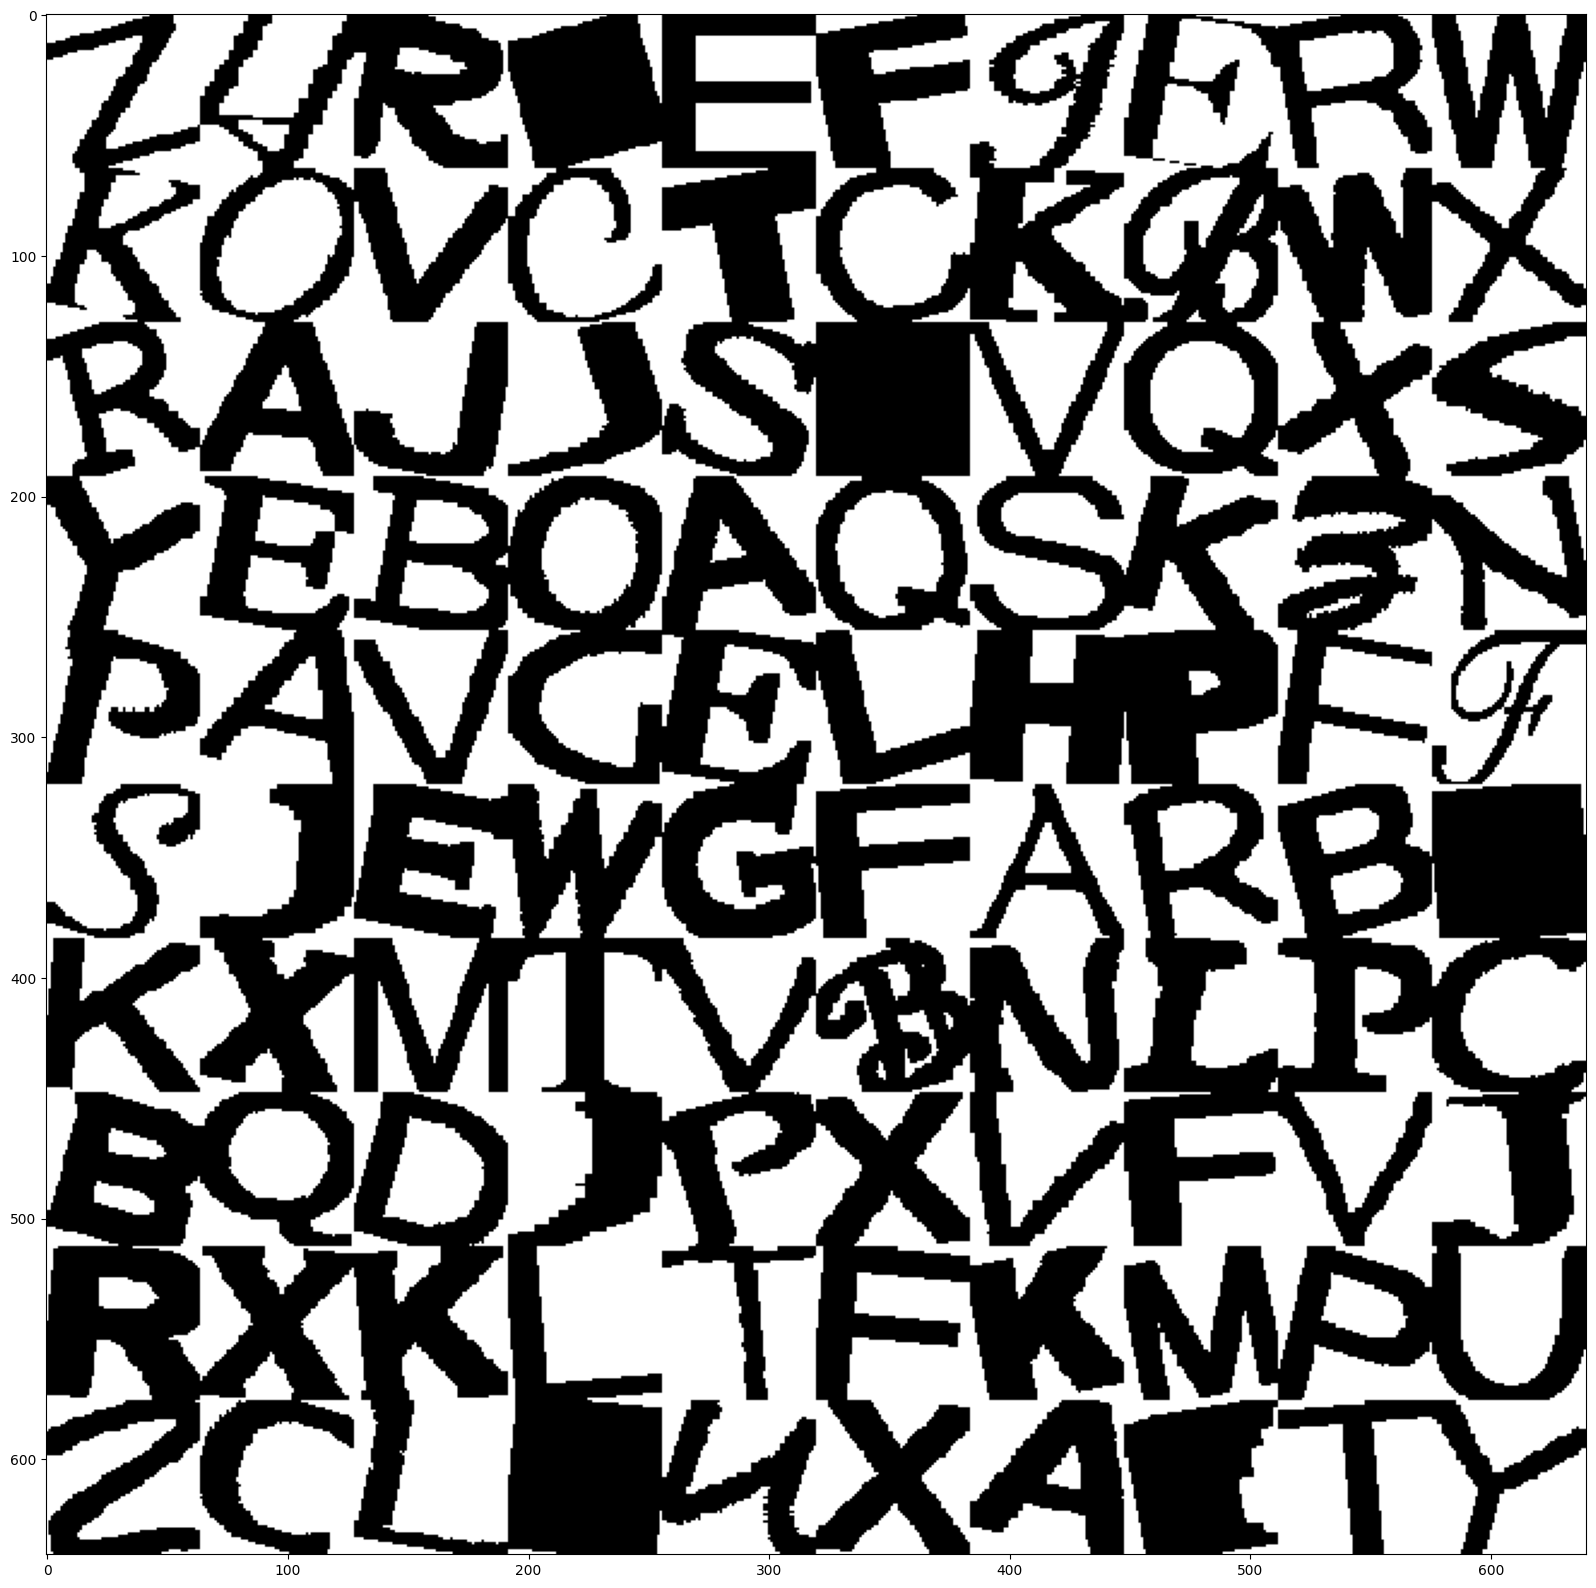

In [1755]:
plt.figure(figsize=(20, 20))

hstacks = []
np.random.seed(0)
for _ in range(10):
    idx = np.random.choice(len(train_images_augmented), 10)
    sample = train_images_augmented[idx]
    hstacks.append(np.hstack(sample))
    
show(np.vstack(hstacks))


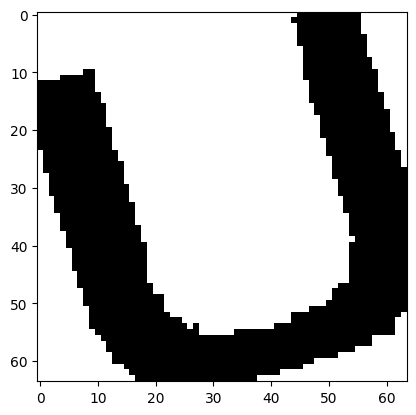

In [1756]:
show(train_images_augmented[0])

In [1757]:
if not os.path.exists('dataset'):
    os.mkdir('dataset')
for l in language:
    l = l.upper()
    if not os.path.exists(f'dataset/{l}{l}'):
        os.mkdir(f'dataset/{l}{l}')
        
    image_paths = sorted(glob.glob("*/*.png"))
    image_paths = [i for i in image_paths if f'{l}{l}' in i]
    train_labels = np.array(list(range(26)))
    classes = sorted(set([i[:i.index('/')] for i in image_paths]))
    classes_fmap = dict(zip(classes, train_labels))
    classes_imap = dict(zip(train_labels, classes))

    train_images = [resize(read(x), size=(size, size))//255 for x in image_paths]
    train_labels = np.stack([classes_fmap[i[:i.index('/')]] for i in image_paths])
    train_images = np.stack(train_images)
    train_images_augmented, train_labels_augmented = augment(train_images, train_labels, 
                                                         erode_depth=erode_depth, 
                                                         dilate_depth=dilate_depth,
                                                         r_from=r_from,
                                                         r_to=r_to,
                                                         r_step=r_step)
    for i in range(len(train_images_augmented)):
        cv2.imwrite(f'dataset/{l}{l}/{i}.png', train_images_augmented[i]*255)


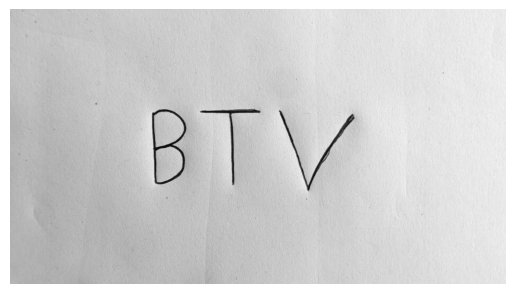

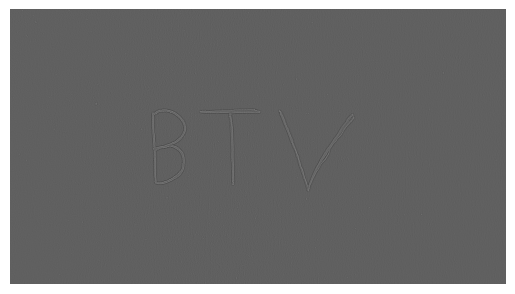

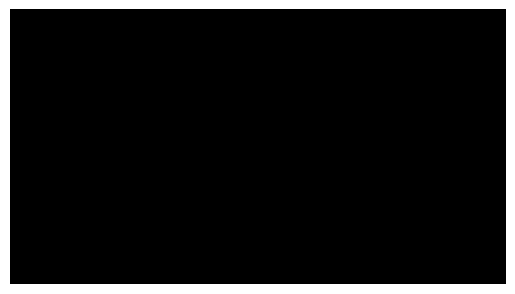

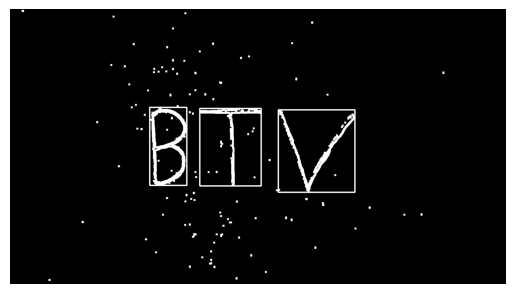

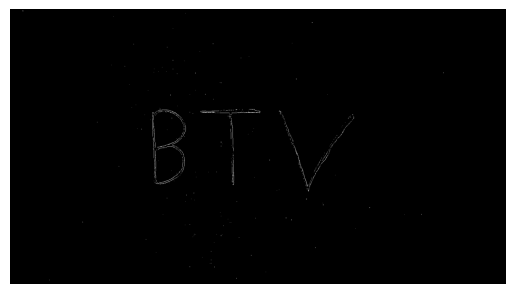

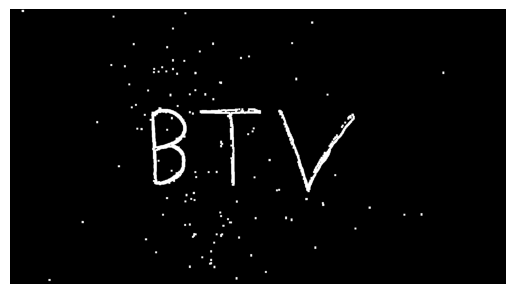

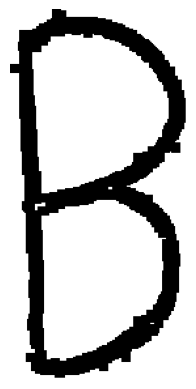

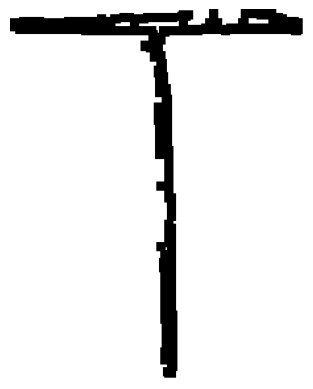

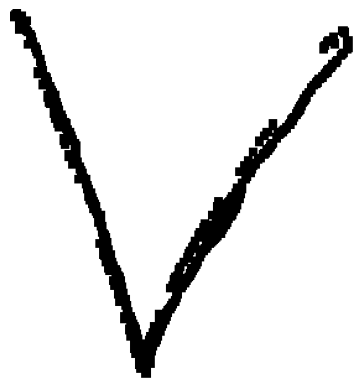

'BTV'

In [246]:
ocr_nn('btv.png', show_steps=True)

#### Presentation

In [247]:
ocr_nn('processing.png', show_steps=False)

'PROCESSLNG'

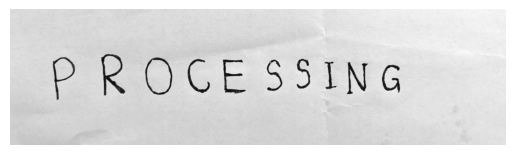

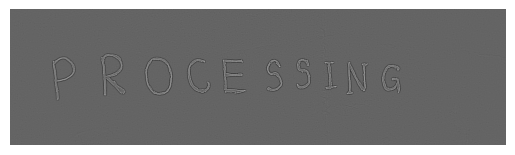

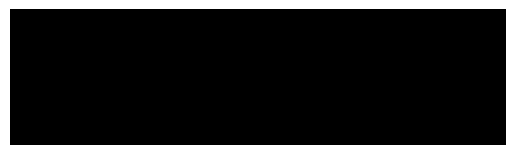

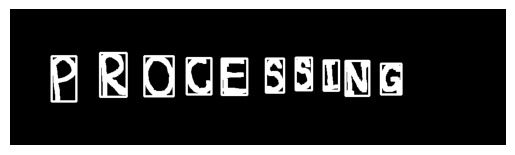

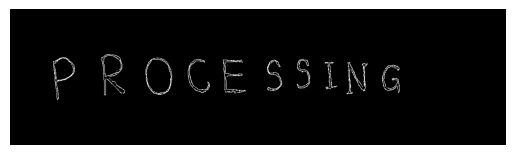

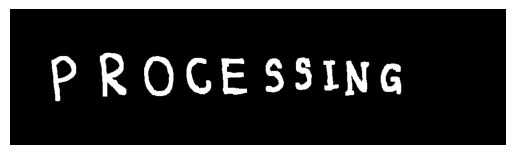

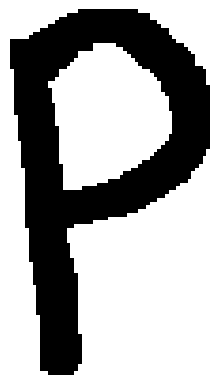

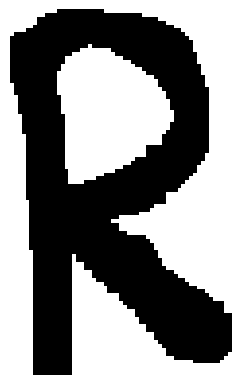

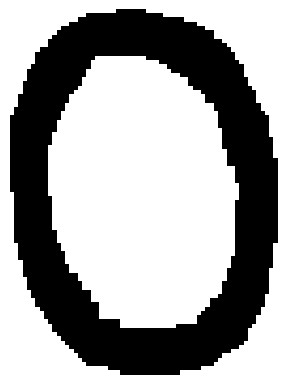

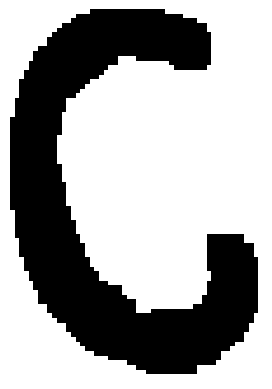

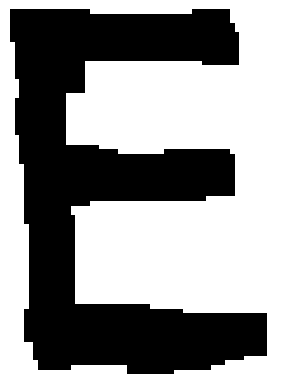

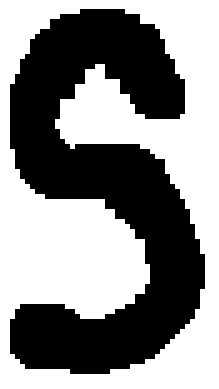

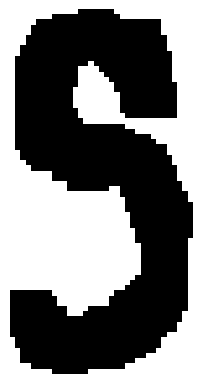

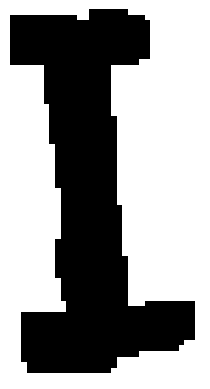

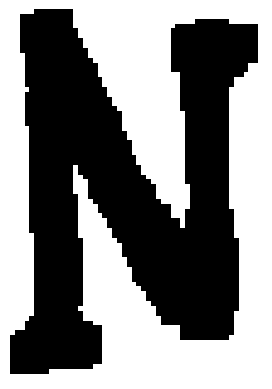

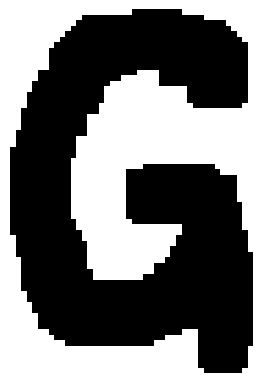

'PROCESSLNG'

In [248]:
ocr_nn('processing.png', show_steps=True)

In [ ]:
ocr_nn('multiline.mpng', show_steps=True)

In [156]:
ocr_nn('multiline.mpng', show_steps=False)

'FMI\nIMAGE\nPROCESSLNG'

In [155]:
ocr_nn('multiline-2.mpng', show_steps=False)


'TACTICAL\nDFGYTAL'

In [150]:
ocr_nn('mazalo.mpng', show_steps=False)


'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO'

In [209]:
ocr_nn('screenshot.png', show_steps=False)

'OCR\nGEORGWPACHOV\nWMAGEPROCESSWNG\nCOURSE'

In [210]:
ocr_nn('bigtext.png', show_steps=False)

'CAPSLOCKWSALLTHE\nWGETHESEDAYS\nSOMEFANCYTWTLE\nLOTSANDLOTSOFTER\nANDMMPLESAND\nPACESTOFAWL'

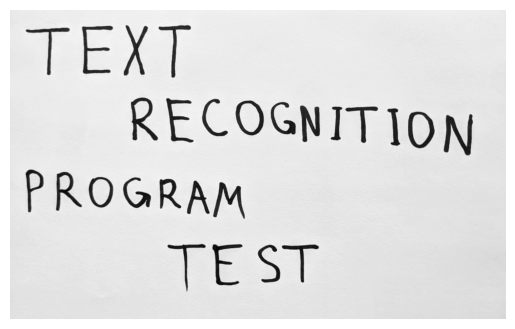

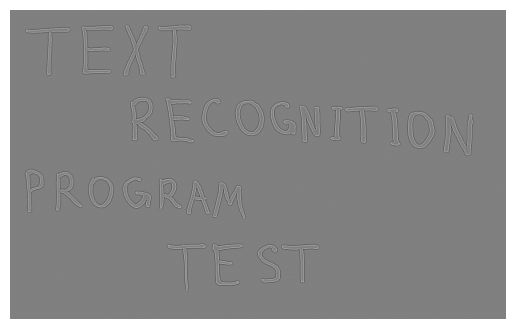

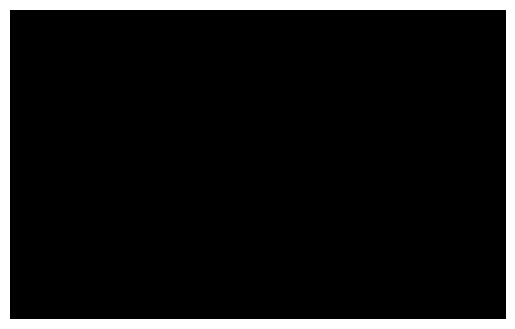

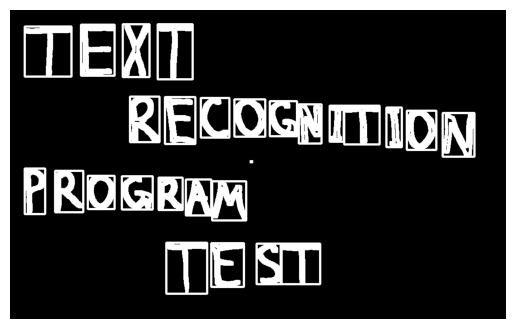

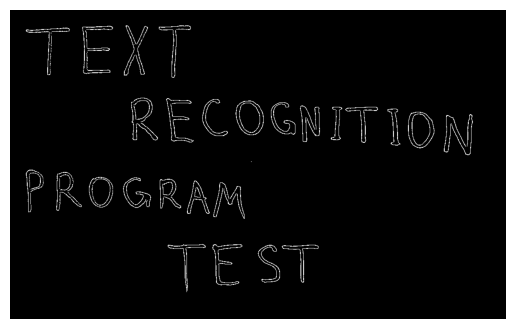

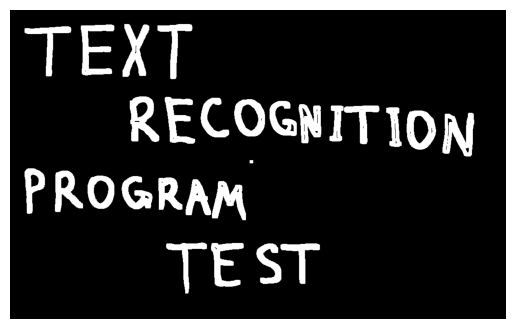

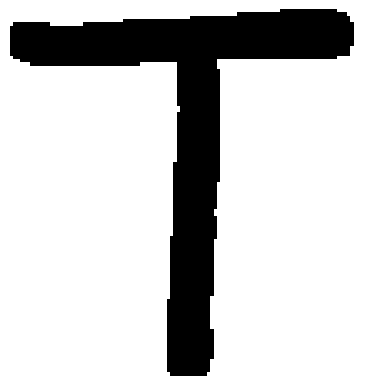

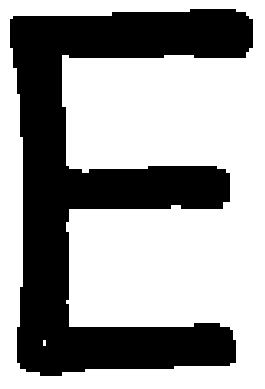

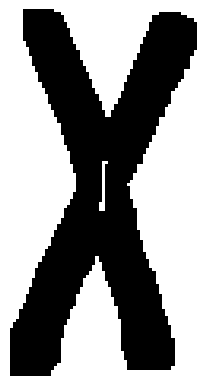

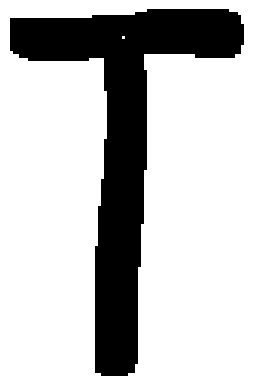

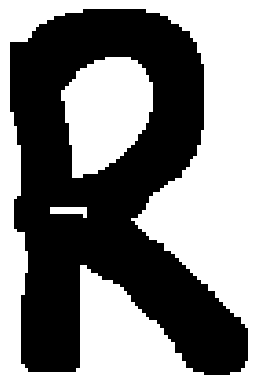

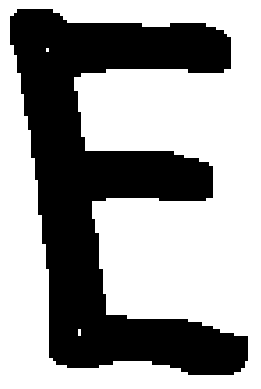

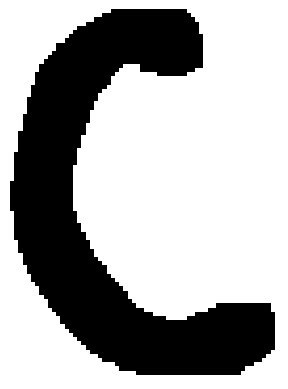

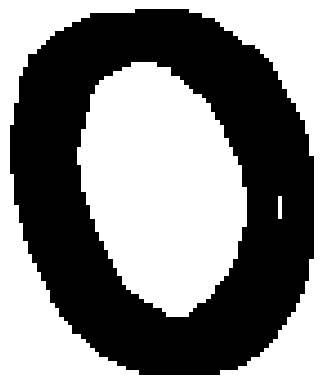

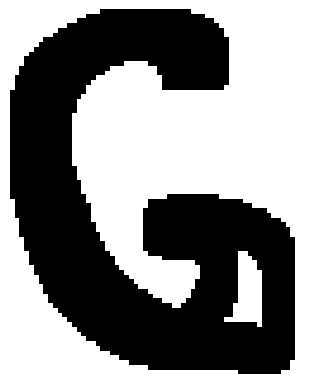

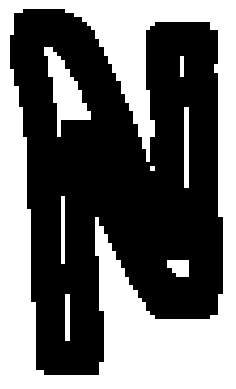

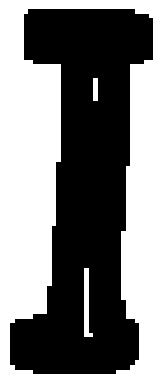

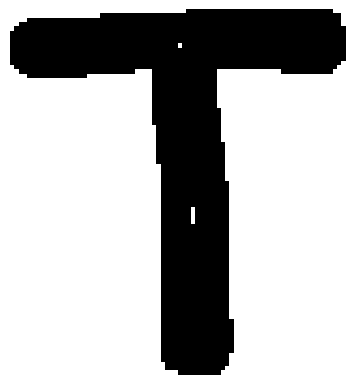

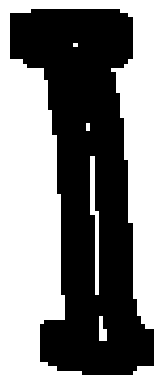

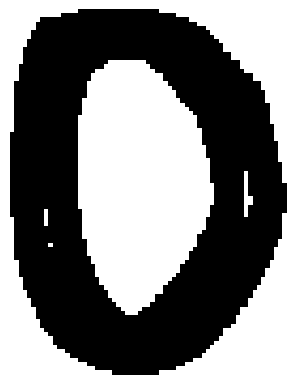

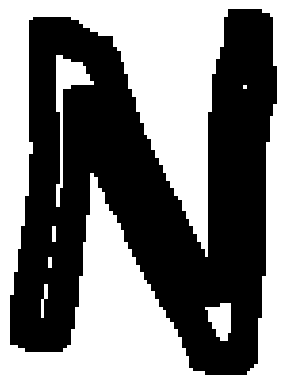

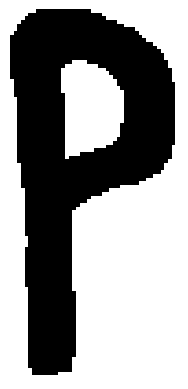

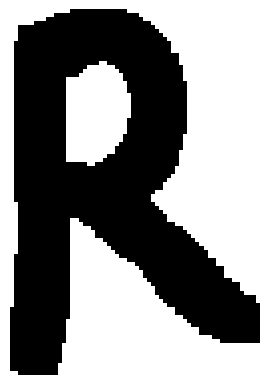

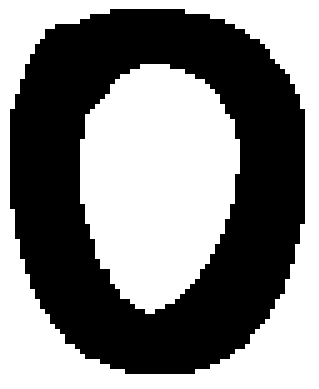

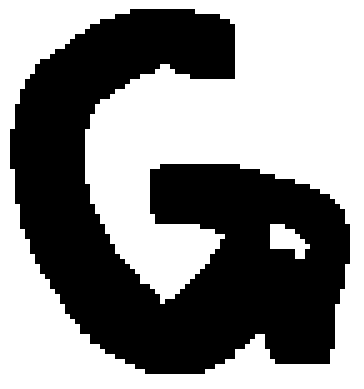

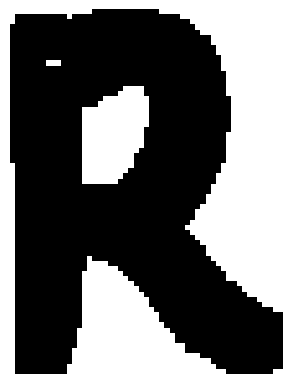

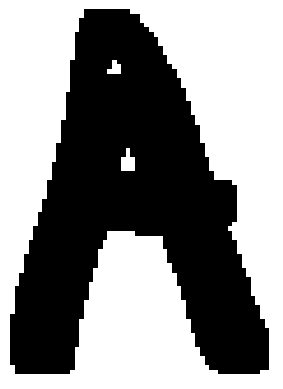

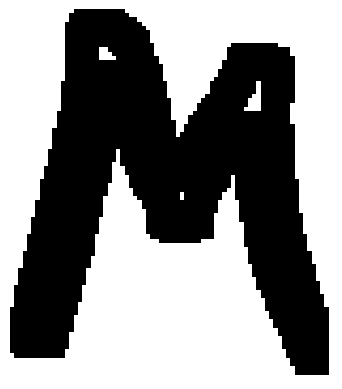

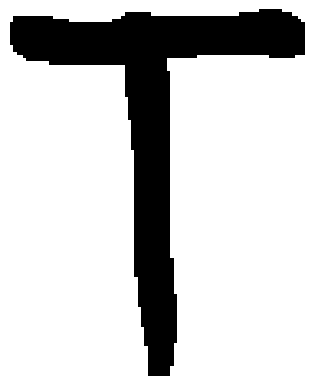

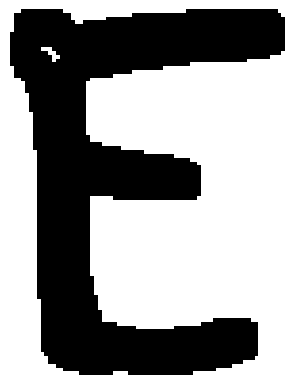

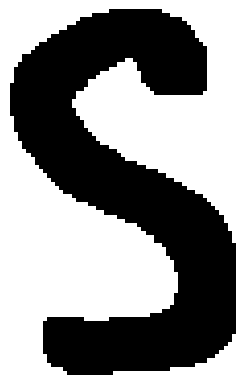

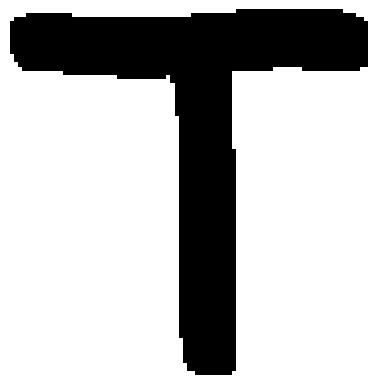

'TEXT\nRECDGNNTIDN\nPROGRAM\nTEST'

In [249]:
ocr_nn('trt1.png', show_steps=True)

In [250]:
ocr_nn('guitar.png', show_steps=False)

'ON THE GULTAW\nVASKO THE\nFROG'